### svm代码实现，增加了核函数的实现

In [1]:
from numpy import *
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.patches import Circle

In [2]:
def loadDataSet(fileName):
    dataMat = []; labelMat = []
    fr = open(fileName)
    for line in fr.readlines():
        lineArr = line.strip().split('\t')
        dataMat.append([float(lineArr[0]), float(lineArr[1])])
        labelMat.append(float(lineArr[2]))
    return dataMat,labelMat


In [3]:
def selectJrand(i,m):
    j=i
    while (j==i):
        j = int(random.uniform(0,m))
    return j

In [4]:
def clipAlpha(aj,H,L):
    if aj > H:
        aj = H
    if L > aj:
        aj = L
    return aj

<img src="images/06.png" align="left"/>

In [5]:
#核函数
def kernelTrans(X, A, kTup):
    m, n = shape(X)
    K = mat(zeros((m, 1)))
    if kTup[0] == 'lin':#线性核
        K = X * A.T
    elif kTup[0] == 'rbf':#高斯核
        for j in range(m):
            deltaRow = X[j, :] - A
            K[j] = deltaRow * deltaRow.T
        K = exp(K / (-2 * kTup[1] ** 2))
    else:
        raise NameError('Houston We Have a Problem -- \
    That Kernel is not recognized')
    return K

In [6]:
class optStruct:
    def __init__(self, dataMatIn, classLabels, C, toler, kTup):
        self.X = dataMatIn
        self.labelMat = classLabels
        self.C = C
        self.tol = toler
        self.m = shape(dataMatIn)[0]
        self.alphas = mat(zeros((self.m, 1)))
        self.b = 0
        self.eCache = mat(zeros((self.m, 2))) #第一列是标志位，0无效 1有效
        self.K = mat(zeros((self.m, self.m)))
        for i in range(self.m):
            self.K[:, i] = kernelTrans(self.X, self.X[i, :], kTup)


In [7]:
def calcEk(oS, k):
    fXk = float(multiply(oS.alphas, oS.labelMat).T * oS.K[:, k] + oS.b)
    Ek = fXk - float(oS.labelMat[k])
    return Ek


In [8]:
#选择第二个待优化的alpha j，选择一个误差最大的alpha j
def selectJ(i, oS, Ei):
    maxK = -1;
    maxDeltaE = 0;
    Ej = 0
    oS.eCache[i] = [1, Ei]  #设为有效
    validEcacheList = nonzero(oS.eCache[:, 0].A)[0]
    if (len(validEcacheList)) > 1:
        for k in validEcacheList:  #迭代所有有效的缓存，找到误差最大的E
            if k == i: continue  #不选择和i相等的值
            Ek = calcEk(oS, k)
            deltaE = abs(Ei - Ek)
            if (deltaE > maxDeltaE):
                maxK = k;
                maxDeltaE = deltaE;
                Ej = Ek
        return maxK, Ej
    else:  #第一次循环时是没有有效的缓存值得，所以随机选一个(仅会执行一次)
        j = selectJrand(i, oS.m)
        Ej = calcEk(oS, j)
    return j, Ej

In [9]:
def updateEk(oS, k):  #更新缓存
    Ek = calcEk(oS, k)
    oS.eCache[k] = [1, Ek]

In [10]:
def innerL(i, oS):
    Ei = calcEk(oS, i)
    if ((oS.labelMat[i] * Ei < -oS.tol) and (oS.alphas[i] < oS.C)) or (
            (oS.labelMat[i] * Ei > oS.tol) and (oS.alphas[i] > 0)):
        j, Ej = selectJ(i, oS, Ei)  #这里不再是随机选取了
        alphaIold = oS.alphas[i].copy()
        alphaJold = oS.alphas[j].copy()
        if (oS.labelMat[i] != oS.labelMat[j]):
            L = max(0, oS.alphas[j] - oS.alphas[i])
            H = min(oS.C, oS.C + oS.alphas[j] - oS.alphas[i])
        else:
            L = max(0, oS.alphas[j] + oS.alphas[i] - oS.C)
            H = min(oS.C, oS.alphas[j] + oS.alphas[i])
        if L == H: print("L==H");return 0
        eta = 2.0 * oS.K[i, j] - oS.K[i, i] - oS.K[j, j]  # 这里的计算要使用核函数了
        if eta >= 0: print("eta>=0"); return 0
        oS.alphas[j] -= oS.labelMat[j] * (Ei - Ej) / eta
        oS.alphas[j] = clipAlpha(oS.alphas[j], H, L)
        updateEk(oS, j)  #这里增加了更新缓存的方法
        if (abs(oS.alphas[j] - alphaJold) < 0.00001): print("j not moving enough");return 0
        oS.alphas[i] += oS.labelMat[j] * oS.labelMat[i] * (alphaJold - oS.alphas[j])
        updateEk(oS, i)  #这里增加了更新缓存的方法
        b1 = oS.b - Ei - oS.labelMat[i] * (oS.alphas[i] - alphaIold) * oS.K[i, i] - oS.labelMat[j] * (
                    oS.alphas[j] - alphaJold) * oS.K[i, j]
        b2 = oS.b - Ej - oS.labelMat[i] * (oS.alphas[i] - alphaIold) * oS.K[i, j] - oS.labelMat[j] * (
                    oS.alphas[j] - alphaJold) * oS.K[j, j]
        if (0 < oS.alphas[i]) and (oS.C > oS.alphas[i]):
            oS.b = b1
        elif (0 < oS.alphas[j]) and (oS.C > oS.alphas[j]):
            oS.b = b2
        else:
            oS.b = (b1 + b2) / 2.0
        return 1
    else:
        return 0

In [11]:
#完整的改进后的使用核函数的SMO算法
def smo(dataMatIn, classLabels, C, toler, maxIter, kTup=('lin', 0)):
    oS = optStruct(mat(dataMatIn), mat(classLabels).transpose(), C, toler, kTup)
    iter = 0
    entireSet = True
    alphaPairsChanged = 0
    while (iter < maxIter) and ((alphaPairsChanged > 0) or (entireSet)):
        alphaPairsChanged = 0
        if entireSet:  #遍历全部数据集
            for i in range(oS.m):
                alphaPairsChanged += innerL(i, oS)
                print("fullSet, iter: %d i:%d, pairs changed %d" % (iter, i, alphaPairsChanged))
            iter += 1
        else:  #遍历非边界数据集
            nonBoundIs = nonzero((oS.alphas.A > 0) * (oS.alphas.A < C))[0]
            for i in nonBoundIs:
                alphaPairsChanged += innerL(i, oS)
                print("non-bound, iter: %d i:%d, pairs changed %d" % (iter, i, alphaPairsChanged))
            iter += 1
        if entireSet:
            entireSet = False  #进行切换
        elif (alphaPairsChanged == 0):
            entireSet = True
        print("iteration number: %d" % iter)
    return oS.b, oS.alphas


In [12]:
def calcWs(alphas, dataArr, classLabels):
    X = mat(dataArr);
    labelMat = mat(classLabels).transpose()
    m, n = shape(X)
    w = zeros((n, 1))
    for i in range(m):
        w += multiply(alphas[i] * labelMat[i], X[i, :].T)
    return w

L==H
fullSet, iter: 0 i:0, pairs changed 0
fullSet, iter: 0 i:1, pairs changed 1
fullSet, iter: 0 i:2, pairs changed 2
fullSet, iter: 0 i:3, pairs changed 3
fullSet, iter: 0 i:4, pairs changed 3
fullSet, iter: 0 i:5, pairs changed 4
fullSet, iter: 0 i:6, pairs changed 4
fullSet, iter: 0 i:7, pairs changed 4
fullSet, iter: 0 i:8, pairs changed 5
fullSet, iter: 0 i:9, pairs changed 5
fullSet, iter: 0 i:10, pairs changed 6
fullSet, iter: 0 i:11, pairs changed 7
fullSet, iter: 0 i:12, pairs changed 8
fullSet, iter: 0 i:13, pairs changed 9
fullSet, iter: 0 i:14, pairs changed 10
fullSet, iter: 0 i:15, pairs changed 11
fullSet, iter: 0 i:16, pairs changed 12
fullSet, iter: 0 i:17, pairs changed 13
fullSet, iter: 0 i:18, pairs changed 13
fullSet, iter: 0 i:19, pairs changed 13
fullSet, iter: 0 i:20, pairs changed 13
fullSet, iter: 0 i:21, pairs changed 14
fullSet, iter: 0 i:22, pairs changed 15
fullSet, iter: 0 i:23, pairs changed 16
fullSet, iter: 0 i:24, pairs changed 17
j not moving enough

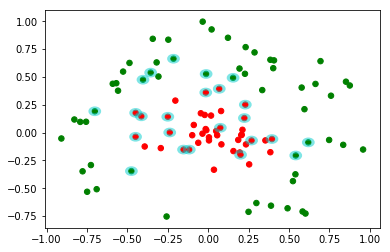

In [13]:
dataMat,labelMat = loadDataSet('data/svm2.txt')
#画图
fig = plt.figure()
ax = fig.add_subplot(111)
cm_dark = mpl.colors.ListedColormap(['g', 'r'])
ax.scatter(array(dataMat)[:,0],array(dataMat)[:,1],c=array(labelMat).squeeze(),cmap=cm_dark,s=30)
# plt.show()
###########
b,alphas = smo(dataMat,labelMat,200,0.0001,10000,('rbf',1.3))
w = calcWs(alphas,dataMat,labelMat)
print('b=',b)
print('alphas=',alphas)
print('w=',w)

###########
#画支持向量
alphas_non_zeros_index = where(alphas>0)
for i in alphas_non_zeros_index[0]:
    circle = Circle((dataMat[i][0], dataMat[i][1]), 0.03, facecolor='none', edgecolor=(0,0.8,0.8), linewidth=3, alpha=0.5)
    ax.add_patch(circle)
plt.show()